# Analiza projektów kickstarter

## Przygotowanie bibliotek wykorzystywanych w systemie

W systemie wykorzystywane są następujące biblioteki

- **pandas** - odczyt, zapis i operacje na danych
- **datetime** - operacje na datach
- **numpy** - liczne funckje matematyczne
- **sklearn** - funkcje wykorzytywane w analizie PCA

In [77]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import numpy as np

## Przygotowanie początkowych stanów systemu

In [78]:
# Skonfigurowanie maksymalnej liczby wyświetlanych kolumn
pd.set_option('display.max_columns', 10)

# Skonfigurowanie opcji wyświetlania
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Parametry wykorzystywane przy wczytywaniu danych
dataset_path = './data/kickstarter-projects-1-filtered.csv'
encoding='ISO-8859-1'
rows_number = 1000
all_columns = ['main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'country', 'usd_pledged']

# Dane wykorzystywane przy przetwarzaniu danych
features_columns = ['main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'backers', 'country', 'usd_pledged']
labels_columns = ['state']

## Przygotowanie danych

 ### Wczytanie danych

In [79]:
df = pd.read_csv(dataset_path, encoding=encoding,low_memory=False).head(rows_number).filter(all_columns, axis=1)
print(df.head())

  main_category currency        deadline   goal        launched pledged       state backers country usd_pledged
0    Publishing      GBP  09-10-15 11:36   1000  11-08-15 12:12       0      failed       0      GB           0
1  Film & Video      USD   26-02-13 0:20  45000   12-01-13 0:20     220      failed       3      US         220
2         Music      USD   16-04-12 4:24   5000   17-03-12 3:24       1      failed       1      US           1
3  Film & Video      USD   29-08-15 1:00  19500   04-07-15 8:35    1283    canceled      14      US        1283
4          Food      USD  01-04-16 13:38  50000  26-02-16 13:38   52375  successful     224      US       52375


### Konwersja danych tekstowych na dane liczbowe

Aby dane mogły zostać poprawnie przetworzone w dalszych krokach przy użyciu metody PCA, dane tekstowe należy zamienić na dane liczbowe. Do tego celu można wykorzystać słowniki. Algorytm konwersji jest następujący:
- zebrać wszystkie wartości występujące w danej kolumnie
- przyporządkować każdej wartości kolejną liczbę naturalną rozpoczynając od jedynki.

#### Metody pomocnicze

In [80]:
def get_all_values_from_column(df, col_name):
    values = []
    for i in range(0, len(df[col_name])):
        category = df[col_name][i]
        if category not in values:
            values.append(category)

    return values


def create_label_number_dict(names):
    normalized = {}
    for i in range(0, len(names)):
        name = names[i]
        normalized[name] = i + 1

    return normalized

def map_text_to_number(df, column_name, dict):
    mapped = pd.Series(df[column_name].map(dict), name=column_name)
    df.update(mapped)

    return df

#### Zbieranie danych i tworzenie słowników

In [81]:
categories = get_all_values_from_column(df, 'main_category')
countries = get_all_values_from_column(df, 'country')
states = get_all_values_from_column(df, 'state')
currencies = get_all_values_from_column(df, 'currency')

categories_dict = create_label_number_dict(categories)
countries_dict = create_label_number_dict(countries)
states_dict = create_label_number_dict(states)
currencies_dict = create_label_number_dict(currencies)

#### Konwersja

In [82]:
# Map string values to number values
df = map_text_to_number(df, 'main_category', categories_dict)
df = map_text_to_number(df, 'country', countries_dict)
df = map_text_to_number(df, 'state', states_dict)
df = map_text_to_number(df, 'currency', currencies_dict)

### Konwersja dat na dane liczbowe

W przypadku dat przyjęto strategię reprezentacji ich jako **timestamp**

#### Metody pomocnicze

In [83]:
def date_to_timestamp(dt):
    return int(datetime.strptime(dt, "%d-%m-%y %H:%M").timestamp())


def map_date_to_timestamp(df, column_names):
    for column_name in column_names:
        mapped = pd.Series(df[column_name].map(date_to_timestamp), name=column_name)
        df.update(mapped)

    return df

#### Konwersja

In [84]:
df = map_date_to_timestamp(df, ['launched', 'deadline'])

### Dodanie sztucznej kolumny _pledged_ratio_

Kolumna ma określić jaki procent założonej sumy został zebrany

In [85]:
df['pledged_ratio'] = df['pledged'].astype(float) / df['goal'].astype(float) * 100

### Prezentacja przetworzonych danych

In [86]:
print(df.head())

  main_category currency    deadline   goal    launched pledged state backers country usd_pledged  pledged_ratio
0             1        1  1444383360   1000  1439287920       0     1       0       1           0       0.000000
1             2        2  1361834400  45000  1357946400     220     1       3       2         220       0.488889
2             3        2  1334543040   5000  1331951040       1     1       1       2           1       0.020000
3             2        2  1440802800  19500  1435991700    1283     2      14       2        1283       6.579487
4             4        2  1459510680  50000  1456490280   52375     3     224       2       52375     104.750000


Dla poprawności dalszych kroków można sprawdzić, czy któreś kolumny nie zawierają niepoprawnych/pustych danych

In [87]:
is_any_nan = False
for column in all_columns:
    is_any_nan = is_any_nan or df[column].isnull().values.any()

print(f'\nCzy istnieją nieprawidłowe wartości w zbiorze danych: {is_any_nan}\n')


Czy istnieją nieprawidłowe wartości w zbiorze danych: False



## Wybór cech i etykiet

### Cechy

In [88]:
features = df[features_columns]
print(features.head())

  main_category currency    deadline   goal    launched pledged backers country usd_pledged
0             1        1  1444383360   1000  1439287920       0       0       1           0
1             2        2  1361834400  45000  1357946400     220       3       2         220
2             3        2  1334543040   5000  1331951040       1       1       2           1
3             2        2  1440802800  19500  1435991700    1283      14       2        1283
4             4        2  1459510680  50000  1456490280   52375     224       2       52375


### Etykiety

In [89]:
labels = df[labels_columns]
print(labels.head())

  state
0     1
1     1
2     1
3     2
4     3


## Analiza PCA

TODO: Parę słów o analizie PCA


### Przeskalowanie wartości

In [90]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
print(features_scaled)

[[-1.20147843 -1.0721321   0.84639537 ... -0.30152763 -0.72740458
  -0.2185112 ]
 [-0.95587777 -0.16584968 -0.73072894 ... -0.29207604 -0.17255745
  -0.21210636]
 [-0.71027711 -0.16584968 -1.25213912 ... -0.2983771  -0.17255745
  -0.21848209]
 ...
 [-0.46467645 -0.16584968  0.79615679 ... -0.28892551 -0.17255745
  -0.20511927]
 [ 0.02652487 -0.16584968  0.22130177 ... -0.2763234  -0.17255745
  -0.21766693]
 [-1.20147843 -0.16584968  1.36455459 ... -0.28892551 -0.17255745
  -0.21656064]]


### Stworzenie macierzy kowariancji i wygenerowanie heatmapy

[[ 1.001001    0.03871573  0.17445684  0.01005308  0.174253    0.04457797
   0.06044046  0.01781315  0.0589271 ]
 [ 0.03871573  1.001001    0.20919081  0.06197439  0.20836352  0.18194163
  -0.02415798  0.92721733 -0.01396047]
 [ 0.17445684  0.20919081  1.001001    0.08238838  1.00080423  0.07650704
   0.04975464  0.20862437  0.03672685]
 [ 0.01005308  0.06197439  0.08238838  1.001001    0.07894365  0.09065705
   0.00672139  0.07039577  0.02561071]
 [ 0.174253    0.20836352  1.00080423  0.07894365  1.001001    0.0762661
   0.04957644  0.20783757  0.0365563 ]
 [ 0.04457797  0.18194163  0.07650704  0.09065705  0.0762661   1.001001
   0.5921328   0.18633586  0.73798222]
 [ 0.06044046 -0.02415798  0.04975464  0.00672139  0.04957644  0.5921328
   1.001001   -0.02028535  0.7078132 ]
 [ 0.01781315  0.92721733  0.20862437  0.07039577  0.20783757  0.18633586
  -0.02028535  1.001001   -0.01605096]
 [ 0.0589271  -0.01396047  0.03672685  0.02561071  0.0365563   0.73798222
   0.7078132  -0.01605096 

<AxesSubplot:>

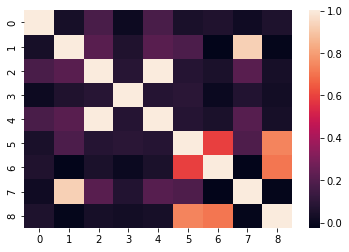

In [91]:
import seaborn as sns
covariance_matrix = np.cov(features_scaled.T)
print(covariance_matrix)
sns.heatmap(covariance_matrix)

Z heatmapy wynika korelacja następujących kolumn:


| Kolumna 1 | Kolumna 2 |
|:---------:|:---------:|
|     7     |     1     |
|     4     |     2     |
|     5     |     8     |
|     6     |     8     |

### Wartości i wektory Eigena

In [92]:
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
print(eigen_values)

[2.60515918e+00 2.20874293e+00 1.59521658e+00 9.32653145e-01
 9.91431312e-01 3.83638343e-01 2.18558680e-01 7.34183867e-02
 1.90445917e-04]
